In [1]:
import pandas as pd
import numpy as np
import csv
import logging
import os
from scipy.stats import pearsonr

from temp_funcs import read_file, merge_dataframes, drop_cols, drop_nans, filter_date_range, \
filter_df, create_container_col, create_cond_df, create_container_df

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

sns.set(context = "notebook", style = "ticks", font="verdana", font_scale = 1.9)
pd.set_option("display.max_colwidth",150) #Expands the number of characters shown in the columns
pd.set_option('display.max_columns', None)

In [2]:
path = "C:/Users/kumar/Documents/Github/analysis_projects/"
csv_path = os.path.join(path, "csv/")
excel_path = os.path.join(path, "excel/")
plot_path = os.path.join(path, "plot/")
path_shiny_human = os.path.join(csv_path, "current_shiny_human.csv")
path_ephys = os.path.join(csv_path, "ephys_hIVSCC_MET.csv")

In [3]:
fields_ephys = ["name", "vrest", "ri", "sag", "tau",
                "upstroke_downstroke_ratio_long_square", "latency", "f_i_curve_slope"]

fields_shiny = ["cell_name", "roi", "cell_specimen_project", "Norm_Marker_Sum.0.4_label",
                "marker_sum_norm_label", "rna_amplification_pass_fail",
                "percent_cdna_longer_than_400bp", "amplified_quantity_ng", "sample_id", 
                "Tree_call", "seurat_prediction_score_label", "seurat_cluster_label",
                "broad_class_label", "subclass_label"]

shiny_dict = {"Norm_Marker_Sum.0.4_label" : "NMS Pass/Fail",
              "rna_amplification_pass_fail" : "RNA Amp Pass/Fail",
              "marker_sum_norm_label": "NMS score",
              "percent_cdna_longer_than_400bp" : "cDNA quality (%>400 bp)",
              "amplified_quantity_ng" : "Amplified content (ng)",
              "seurat_prediction_score_label": "Seurat prediction score"}

##### Filtering shiny

In [4]:
shiny_human = read_file(path_shiny_human, fields_shiny) #3592 rows
shiny_human.rename(columns=shiny_dict, inplace=True)

INFO:temp_funcs:Read file in as a pandas dataframe


In [5]:
shiny_human["region"] = pd.np.where(shiny_human.roi.str.contains("FCx"), "FCx", 
                                    pd.np.where(shiny_human.roi.str.contains("OCx"), "OCx", 
                                    pd.np.where(shiny_human.roi.str.contains("PCx"), "PCx",
                                    pd.np.where(shiny_human.roi.str.contains("TCx"), "TCx", "Unknown/Misc"))))

shiny_human["layer"] = pd.np.where(shiny_human.roi.str.contains("L1"), "L1", 
                                   pd.np.where(shiny_human.roi.str.contains("L2"), "L2",
                                   pd.np.where(shiny_human.roi.str.contains("L3"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L4"), "L4", 
                                   pd.np.where(shiny_human.roi.str.contains("L5"), "L5",
                                   pd.np.where(shiny_human.roi.str.contains("L6"), "L6",
                                   pd.np.where(shiny_human.roi.str.contains("L2-3"), "L2-3",
                                   pd.np.where(shiny_human.roi.str.contains("L3a"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L3b"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L3c"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L6a"), "L6",
                                   pd.np.where(shiny_human.roi.str.contains("LL1"), "LL1", 
                                   pd.np.where(shiny_human.roi.str.contains("LL2"), "LL2", 
                                   pd.np.where(shiny_human.roi.str.contains("LL3"), "LL3",
                                   pd.np.where(shiny_human.roi.str.contains("LL4"), "LL4", 
                                   pd.np.where(shiny_human.roi.str.contains("LL5"), "LL5", "unknown_layer"))))))))))))))))

In [6]:
ephys = read_file(path_ephys, fields_ephys) #1449 rows
ephys.rename(columns={"vrest": "Vm(mV)", "ri": "Input Resistance(MΩ)",
                       "sag" : "Sag Fraction", "tau": "τ(s)",
                       "upstroke_downstroke_ratio_long_square": "LS AP up/downstoke", "latency" : "Latency",
                       "f_i_curve_slope" : "F-I Curve"}, inplace=True)
ephys_list = ["Vm(mV)", "Input Resistance(MΩ)", "Sag Fraction", "τ(s)", 
                      "LS AP up/downstoke", "Latency", "F-I Curve"]
ephys

INFO:temp_funcs:Read file in as a pandas dataframe


,name,Vm(mV),Input Resistance(MΩ),Sag Fraction,τ(s),LS AP up/downstoke,Latency,F-I Curve
0,H19.03.306.11.15.02.06,-65.122929,185.124964,0.102990,24.413168,3.786294,0.05140,0.165000
1,H18.06.004.11.02.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H18.06.004.11.02.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,H18.06.004.11.03.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H19.06.351.11.15.02.01,-60.251895,561.418355,0.015036,37.969562,3.603331,0.03658,0.352966
...,...,...,...,...,...,...,...,...
1444,H20.06.351.11.06.01.04,-65.023605,242.256120,0.161407,23.458603,2.394247,0.02470,0.323529
1445,H20.06.351.11.06.01.05,-65.133683,246.923044,0.077304,21.062437,2.962435,0.02796,0.310000
1446,H20.06.351.11.06.01.06,-69.985204,311.142892,0.071834,23.771703,2.533110,0.02944,0.375000
1447,H20.06.351.11.06.01.08,-61.401253,309.951991,0.213605,17.061975,2.534424,0.02004,0.425000


##### Human Layer 4 DF

In [7]:
h_l4 = filter_df(shiny_human, "layer", "L4")
h_l4 = create_cond_df(h_l4, "region", ["FCx", "OCx", "PCx", "TCx"]) #473 rows

INFO:temp_funcs:Filtered dataframe based on layer == L4
INFO:temp_funcs:Created a conditional dataframe based on region containing ['FCx', 'OCx', 'PCx', 'TCx']


In [8]:
merged = merge_dataframes(h_l4, ephys, "cell_name", "name", "inner") #379 rows

INFO:temp_funcs:Merged two pandas dataframe into one dataframe


In [9]:
merged

,sample_id,cell_name,roi,cDNA quality (%>400 bp),RNA Amp Pass/Fail,Amplified content (ng),cell_specimen_project,NMS score,NMS Pass/Fail,seurat_cluster_label,Seurat prediction score,broad_class_label,subclass_label,Tree_call,region,layer,name,Vm(mV),Input Resistance(MΩ),Sag Fraction,τ(s),LS AP up/downstoke,Latency,F-I Curve
0,P8S4_180718_354_A01,H18.03.313.11.06.01.05,TCx_L4,0.689,Pass,12.936141,hIVSCC-MET,1.112490,True,Inh L1-2 PAX6 CDH12,1.000000,GABAergic neuron,LAMP5/PAX6/Other,Core,TCx,L4,H18.03.313.11.06.01.05,-63.207101,841.105652,0.147336,57.667624,3.333950,0.01846,0.362500
1,PBS4_181212_501_A01,H18.06.371.12.17.01.01,TCx_L4,0.741,Pass,20.640435,hIVSCC-MET,1.066516,True,Inh L1-2 PAX6 TNFAIP8L3,0.697530,GABAergic neuron,LAMP5/PAX6/Other,Core,TCx,L4,H18.06.371.12.17.01.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P8S4_171017_351_A01,H17.06.013.21.10.01,FCx_L4,0.367,Pass,15.216977,hIVSCC-MET,0.940926,True,Inh L1-4 LAMP5 LCP2 (rosehip),0.999842,GABAergic neuron,LAMP5/PAX6/Other,Core,FCx,L4,H17.06.013.21.10.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P8S4_190618_356_A01,H19.03.314.12.07.01.01,TCx_L4,0.479,Pass,35.471986,hIVSCC-MET,0.988428,True,Inh L1-4 LAMP5 LCP2 (rosehip),0.984463,GABAergic neuron,LAMP5/PAX6/Other,Core,TCx,L4,H19.03.314.12.07.01.01,-60.490061,265.750021,0.094790,18.017630,2.811279,0.02972,0.296429
4,P1S4_190813_005_A01,H19.03.319.12.07.01.03,TCx_L4,0.616,Pass,17.497605,hIVSCC-MET,1.372332,True,Inh L2-6 LAMP5 CA1 (Igtp),1.000000,GABAergic neuron,LAMP5/PAX6/Other,Core,TCx,L4,H19.03.319.12.07.01.03,-66.055191,249.234408,0.056897,15.964836,1.796395,0.02458,0.230000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,PES4_190723_659_A01,H19.03.317.11.10.01.10,TCx_L4,0.742,Pass,24.062907,hIVSCC-MET,0.086580,False,Inh L2-4 PVALB WFDC2,0.561645,GABAergic neuron,VIP,PoorQ,TCx,L4,H19.03.317.11.10.01.10,-66.508256,187.656209,0.086031,25.009076,2.772645,0.04842,0.174112
375,PES4_190723_661_A01,H19.03.317.11.10.01.12,TCx_L4,0.560,Pass,8.214780,hIVSCC-MET,0.111813,False,Inh L2-4 PVALB WFDC2,0.442187,GABAergic neuron,VIP,PoorQ,TCx,L4,H19.03.317.11.10.01.12,-55.004411,263.906240,0.179304,26.764876,2.305283,0.04420,0.204977
376,PES4_190813_656_A01,H19.03.319.11.11.01.01,TCx_L4,0.436,Pass,13.414215,hIVSCC-MET,0.269464,False,Inh L2-4 PVALB WFDC2,0.216202,Glutamatergic neuron,IT (L4-6),PoorQ,TCx,L4,H19.03.319.11.11.01.01,-71.589837,174.562499,0.132270,28.874382,4.151645,0.04824,0.182356
377,PES4_190827_655_A01,H19.03.320.11.11.01.01,TCx_L4,0.288,Fail,7.915064,hIVSCC-MET,0.324924,False,Exc L4-5 RORB DAPK2,0.856917,Glutamatergic neuron,IT (L4-6),PoorQ,TCx,L4,H19.03.320.11.11.01.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
merged.dropna(subset=ephys_list, inplace=True) #311 rows

In [12]:
merged

,cell_name,cDNA quality (%>400 bp),RNA Amp Pass/Fail,Amplified content (ng),cell_specimen_project,NMS score,NMS Pass/Fail,seurat_cluster_label,Seurat prediction score,broad_class_label,subclass_label,Tree_call,region,layer,Vm(mV),Input Resistance(MΩ),Sag Fraction,τ(s),LS AP up/downstoke,Latency,F-I Curve
0,H18.03.313.11.06.01.05,0.689,Pass,12.936141,hIVSCC-MET,1.112490,True,Inh L1-2 PAX6 CDH12,1.000000,GABAergic neuron,LAMP5/PAX6/Other,Core,TCx,L4,-63.207101,841.105652,0.147336,57.667624,3.333950,0.01846,0.362500
3,H19.03.314.12.07.01.01,0.479,Pass,35.471986,hIVSCC-MET,0.988428,True,Inh L1-4 LAMP5 LCP2 (rosehip),0.984463,GABAergic neuron,LAMP5/PAX6/Other,Core,TCx,L4,-60.490061,265.750021,0.094790,18.017630,2.811279,0.02972,0.296429
4,H19.03.319.12.07.01.03,0.616,Pass,17.497605,hIVSCC-MET,1.372332,True,Inh L2-6 LAMP5 CA1 (Igtp),1.000000,GABAergic neuron,LAMP5/PAX6/Other,Core,TCx,L4,-66.055191,249.234408,0.056897,15.964836,1.796395,0.02458,0.230000
5,H19.03.302.11.03.01.03,0.666,Pass,16.073146,hIVSCC-MET,1.043932,True,Inh L2-6 LAMP5 CA1 (Igtp),0.960779,GABAergic neuron,LAMP5/PAX6/Other,Core,TCx,L4,-59.083222,353.063971,0.022493,16.070204,2.099504,0.01042,0.348352
7,H19.03.306.11.06.02.01,0.605,Pass,17.100321,hIVSCC-MET,1.401790,True,Inh L2-4 VIP SPAG17,0.518578,GABAergic neuron,VIP,Core,TCx,L4,-63.795358,294.788599,0.204165,21.670489,1.740138,0.07110,0.460714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,H19.03.317.11.10.01.04,0.486,Fail,6.933865,hIVSCC-MET,0.321862,False,Exc L3-5 RORB ESR1,0.520029,Glutamatergic neuron,IT (L4-6),PoorQ,TCx,L4,-72.970275,199.156299,0.132480,21.685570,2.650351,0.03302,0.292367
373,H19.03.317.11.10.01.06,0.348,Fail,5.640186,hIVSCC-MET,0.087728,False,Inh L2-4 PVALB WFDC2,0.356891,Glutamatergic neuron,IT (L2-3),PoorQ,TCx,L4,-68.837412,200.062484,0.084629,23.468343,3.336474,0.03832,0.209756
374,H19.03.317.11.10.01.10,0.742,Pass,24.062907,hIVSCC-MET,0.086580,False,Inh L2-4 PVALB WFDC2,0.561645,GABAergic neuron,VIP,PoorQ,TCx,L4,-66.508256,187.656209,0.086031,25.009076,2.772645,0.04842,0.174112
375,H19.03.317.11.10.01.12,0.560,Pass,8.214780,hIVSCC-MET,0.111813,False,Inh L2-4 PVALB WFDC2,0.442187,GABAergic neuron,VIP,PoorQ,TCx,L4,-55.004411,263.906240,0.179304,26.764876,2.305283,0.04420,0.204977


In [13]:
region_list = ["FCx", "OCx", "PCx", "TCx"]

d = dict()
for region_name in region_list:
    d[region_name] = filter_df(merged, "region", region_name)
    
#d["FCx"] #31 rows
#d["OCx"] #3 rows
#d["PCx"] #2 rows
#d["TCx"] #275 rows

INFO:temp_funcs:Filtered dataframe based on region == FCx
INFO:temp_funcs:Filtered dataframe based on region == OCx
INFO:temp_funcs:Filtered dataframe based on region == PCx
INFO:temp_funcs:Filtered dataframe based on region == TCx


##### Plots

In [14]:
tree_colors={"Core": "#41ab5d", "I1": "#2171b5", "I2": "#4292c6", "I3": "#6baed6", "PoorQ": "#ef3b2c"}

In [15]:
def proplot(df, col_1, col_2):
    df1 = df[[col_1, col_2]]
    df1["group_count"] = df1.groupby([col_1, col_2])[col_2].transform("count")
    df1["group_total"] = df1.groupby(col_1)[col_2].transform("count")
    df1["proportion"] = (df1["group_count"] / df1["group_total"]) * 100

    proportion_table = pd.pivot_table(df1, values="proportion", index=[col_1], columns=col_2, fill_value=0)
    count_table = pd.pivot_table(df1, values="group_count", index=[col_1], columns=col_2, fill_value=0)
    
    fig_dims = (20, 10)
    f, axes = plt.subplots(figsize=fig_dims)
    
    ax = sns.barplot(x=col_1, y="proportion", data=df1, order=["FCx", "OCx", "PCx", "TCx"],
                 hue=col_2, hue_order=tree_colors, palette=tree_colors)
    ax.set(xlabel="Region", ylabel="Percentage of cell proportion")
    plt.xticks(rotation=0)
    plt.ylim(0, 100)

C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be

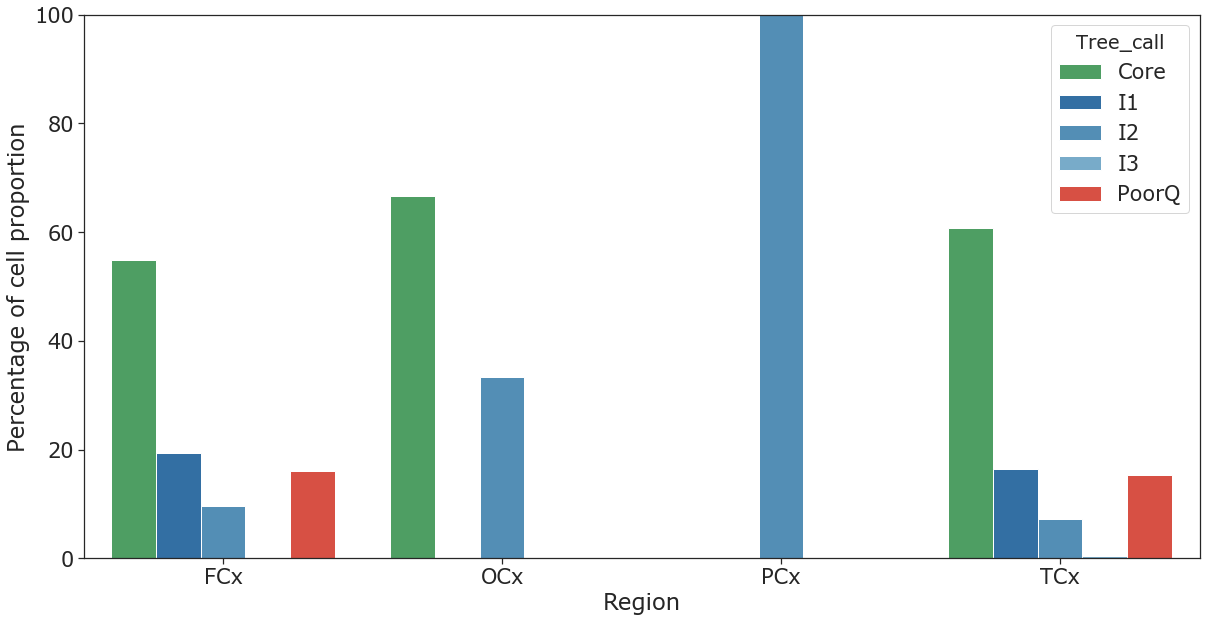

In [16]:
proplot(merged, "region", "Tree_call")

In [17]:
broad_class_colors = {"GABAergic neuron": "#2171b5", "Glutamatergic neuron": "#ef3b2c"}
region_colors = {"FCx": "#2171b5", "TCx": "#ef3b2c"}

KeyError: "['vrest'] not in index"

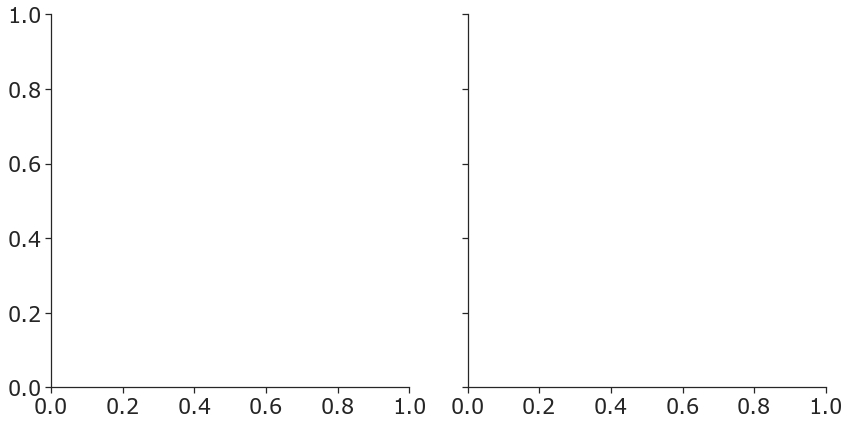

In [18]:
g = sns.FacetGrid(data=merged, col="broad_class_label", height=6, aspect=1)
g = g.map(sns.violinplot, "region", "vrest", order=["FCx", "TCx"], palette=region_colors)
g.set_titles("{col_name}")         
#g.fig.subplots_adjust(wspace=0.05, hspace=0.1)

KeyError: "['ri'] not in index"

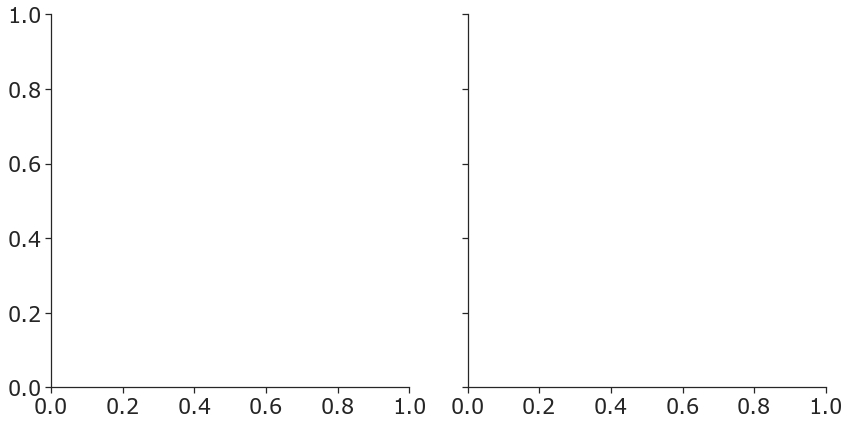

In [19]:
g = sns.FacetGrid(data=merged, col="broad_class_label", height=6, aspect=1)
g = g.map(sns.violinplot, "region", "ri", order=["FCx", "TCx"], palette=region_colors)
g.set_titles("{col_name}")         
#g.fig.subplots_adjust(wspace=0.05, hspace=0.1)

In [ ]:
g = sns.FacetGrid(data=merged, col="broad_class_label", height=6, aspect=1)
g = g.map(sns.violinplot, "region", "tau", order=["FCx", "TCx"], palette=region_colors)
g.set_titles("{col_name}")         
#g.fig.subplots_adjust(wspace=0.05, hspace=0.1)

KeyError: "['sag'] not in index"

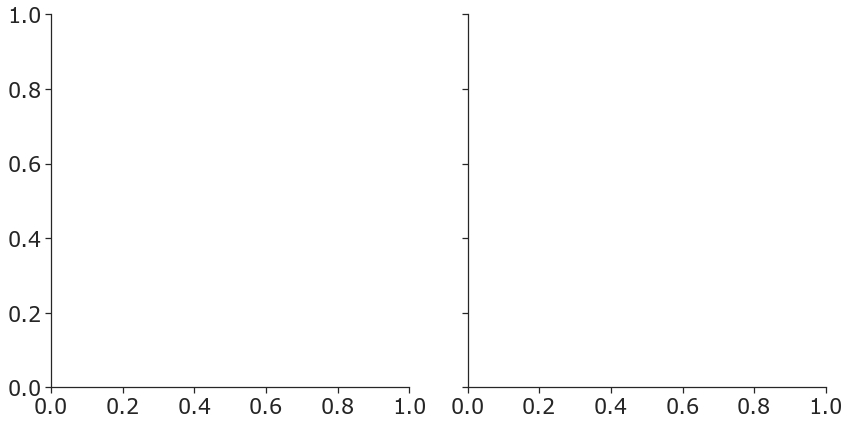

In [20]:
g = sns.FacetGrid(data=merged, col="broad_class_label", height=6, aspect=1)
g = g.map(sns.violinplot, "region", "sag", order=["FCx", "TCx"], palette=region_colors)
g.set_titles("{col_name}")         
#g.fig.subplots_adjust(wspace=0.05, hspace=0.1)
#Sag is higher for FCx

In [ ]:
g = sns.FacetGrid(data=merged, col="region", height=6, aspect=2, hue="broad_class_label", col_order=["TCx"],
                  palette=broad_class_colors)
g = g.map(sns.countplot, "subclass_label")
g.set_titles("{col_name}")         
#g.fig.subplots_adjust(wspace=0.05, hspace=0.1)
#Sag is higher for FCx
for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

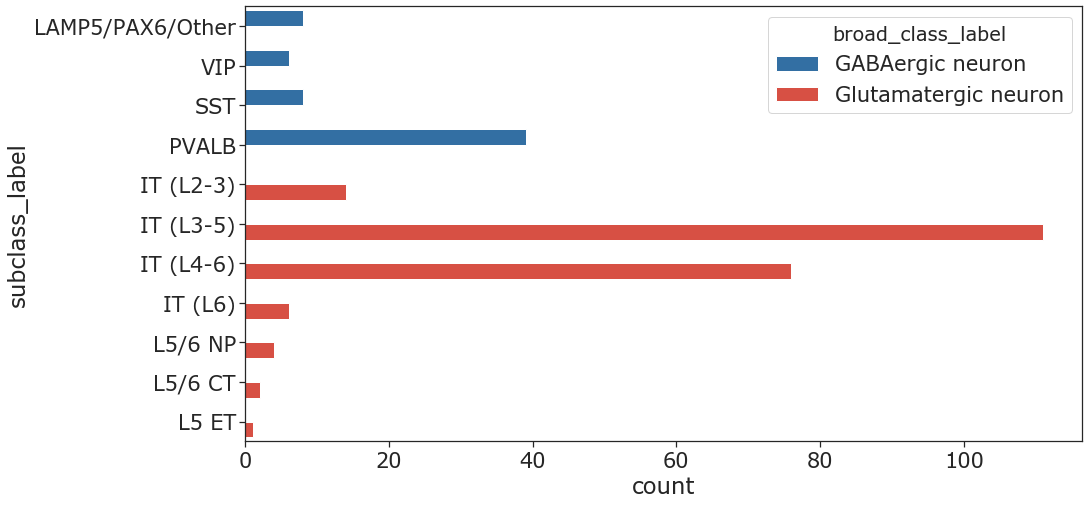

In [21]:
fig, ax = plt.subplots(figsize=(15,8))
sns.countplot(data=d["TCx"], y="subclass_label", hue="broad_class_label", palette=broad_class_colors)

In [32]:
org_list = ["cell_name", "cell_specimen_project", "region", "layer",
            "broad_class_label", "subclass_label", "seurat_cluster_label",
            "Tree_call", "RNA Amp Pass/Fail", "NMS Pass/Fail",
            "cDNA quality (%>400 bp)", "Amplified content (ng)", "NMS score", "Seurat prediction score",
            "Vm(mV)", "Input Resistance(MΩ)", "Sag Fraction", "τ(s)", 
            "LS AP up/downstoke", "Latency", "F-I Curve"]

org_merged = merged[org_list]
org_fcx = d["FCx"][org_list]
org_ocx = d["OCx"][org_list]
org_pcx = d["PCx"][org_list]
org_tcx = d["TCx"][org_list]

In [34]:
writer = pd.ExcelWriter(excel_path + "Human_L4.xlsx")
org_merged.to_excel(writer, "Merged", freeze_panes=(1,0))
org_fcx.to_excel(writer, "FCx", freeze_panes=(1,0))
org_ocx.to_excel(writer, "OCx", freeze_panes=(1,0))
org_pcx.to_excel(writer, "PCx", freeze_panes=(1,0))
org_tcx.to_excel(writer, "TCx", freeze_panes=(1,0))
h_l4.to_excel(writer, "human_layer_4", freeze_panes=(1,0))
writer.save()

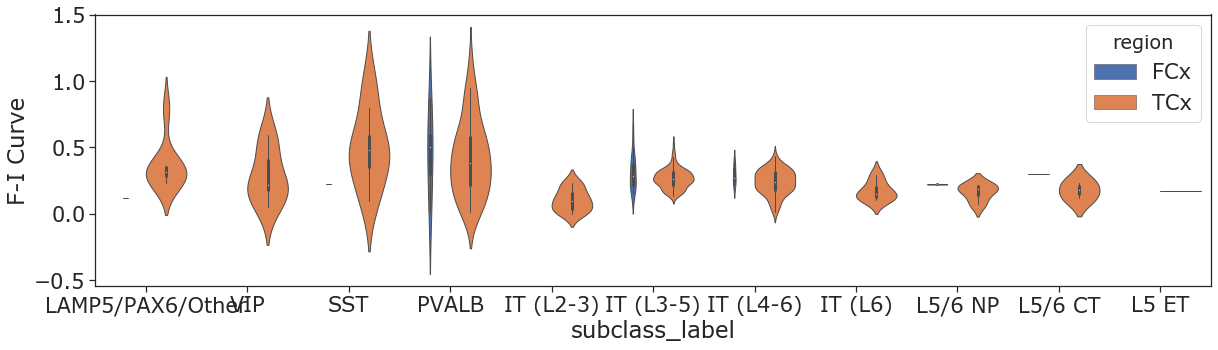

In [24]:
f, axes = plt.subplots(figsize=(20, 5))

sns.violinplot(x="subclass_label", y="F-I Curve", hue="region", data=merged, hue_order=["FCx", "TCx"],
                    scale="count", inner="box", saturation=1, linewidth=1)

NameError: name 's_colors' is not defined

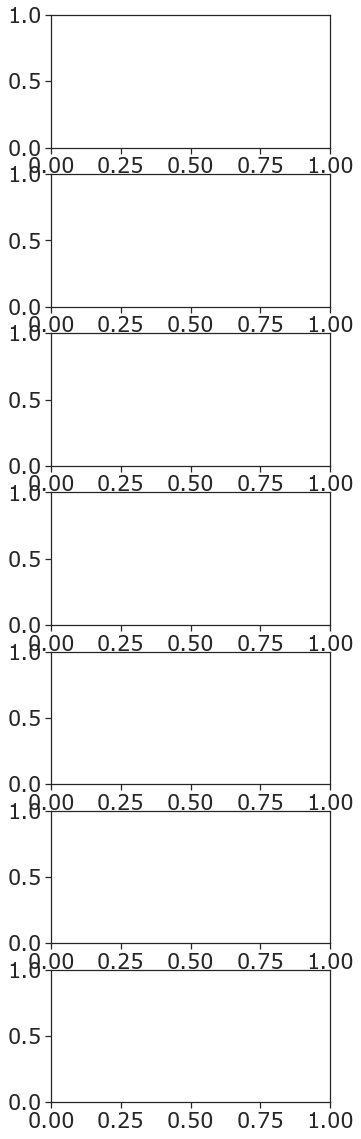

In [25]:
fig_dims = (5, 20)
f, axes = plt.subplots(nrows=7, ncols=1, figsize=fig_dims)

ax = sns.violinplot(x="subclass_label", y="F-I Curve", hue="region", data=merged,
                    scale="count", inner="box", palette=s_colors, saturation=1, linewidth=1, ax=axes[0])
#ax = sns.stripplot(x="subclass_label", y="F-I Curve", hue="region", data=vio_df,
#                   order = sub5_list, hue_order = region_list,
#                   jitter=False, size=3.5, color="0.2", dodge=True, linewidth=0.5, ax=axes[0])

ax1 = sns.violinplot(x="subclass_label", y="Input Resistance(MΩ)", hue="region", data=rsp_visp_glu,
                    order=sub5_list, hue_order=region_list,
                    scale="count", inner="box", palette=s_colors, saturation=1, linewidth=1, ax=axes[1])
#ax1 = sns.stripplot(x="subclass_label", y="Input Resistance(MΩ)", hue="region", data=vio_df,
#                   order = sub5_list, hue_order = region_list,
#                   jitter=False, size=3.5, color="0.2", dodge=True, linewidth=0.5, ax=axes[1])

ax2 = sns.violinplot(x="subclass_label", y="LS AP up/downstoke", hue="region", data=rsp_visp_glu,
                    order=sub5_list, hue_order=region_list,
                    scale="count", inner="box", palette=s_colors, saturation=1, linewidth=1, ax=axes[2])
#ax2 = sns.stripplot(x="subclass_label", y="LS AP up/downstoke", hue="region", data=vio_df,
#                   order = sub5_list, hue_order = region_list,
#                   jitter=False, size=3.5, color="0.2", dodge=True, linewidth=0.5, ax=axes[2])

ax3 = sns.violinplot(x="subclass_label", y="Latency", hue="region", data=rsp_visp_glu,
                    order=sub5_list, hue_order=region_list,
                    scale="count", inner="box", palette=s_colors, saturation=1, linewidth=1, ax=axes[3])
#ax3 = sns.stripplot(x="subclass_label", y="Latency", hue="region", data=vio_df,
#                   order = sub5_list, hue_order = region_list,
#                   jitter=False, size=3.5, color="0.2", dodge=True, linewidth=0.5, ax=axes[3])

ax4 = sns.violinplot(x="subclass_label", y="Sag Fraction", hue="region", data=rsp_visp_glu,
                    order=sub5_list, hue_order=region_list,
                    scale="count", inner="box", palette=s_colors, saturation=1, linewidth=1, ax=axes[4])
#ax4 = sns.stripplot(x="subclass_label", y="Sag Fraction", hue="region", data=vio_df,
#                   order = sub5_list, hue_order = region_list,
#                   jitter=False, size=3.5, color="0.2", dodge=True, linewidth=0.5, ax=axes[4])

ax5 = sns.violinplot(x="subclass_label", y="Vm(mV)", hue="region", data=rsp_visp_glu,
                    order=sub5_list, hue_order=region_list,
                    scale="count", inner="box", palette=s_colors, saturation=1, linewidth=1, ax=axes[5])
#ax5 = sns.stripplot(x="subclass_label", y="Vm(mV)", hue="region", data=vio_df,
#                   order = sub5_list, hue_order = region_list,
#                   jitter=False, size=3.5, color="0.2", dodge=True, linewidth=0.5, ax=axes[5])

ax6 = sns.violinplot(x="subclass_label", y="τ(s)", hue="region", data=rsp_visp_glu,
                    order=sub5_list, hue_order=region_list,
                    scale="count", inner="box", palette=s_colors, saturation=1, linewidth=1, ax=axes[6])
#ax6 = sns.stripplot(x="subclass_label", y="τ(s)", hue="region", data=vio_df,
#                   order = sub5_list, hue_order = region_list,
#                   jitter=False, size=3.5, color="0.2", dodge=True, linewidth=0.5, ax=axes[6])


ax.set(ylim=(0, 0.7))
ax1.set(ylim=(0, 600))
ax2.set(ylim=(0, 7))
ax3.set(ylim=(0, 0.15))
ax4.set(ylim=(0, 0.4))
ax5.set(ylim=(-95, -50))
ax6.set(ylim=(0, 40))

ax.legend_.remove()
ax1.legend_.remove()
ax2.legend_.remove()
ax3.legend_.remove()
ax4.legend_.remove()
ax5.legend_.remove()
ax6.legend_.remove()

ax.set(xticklabels=[])
ax1.set(xticklabels=[])
ax2.set(xticklabels=[])
ax3.set(xticklabels=[])
ax4.set(xticklabels=[])
ax5.set(xticklabels=[])

ax.set_xlabel("")
ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("")
ax4.set_xlabel("")
ax5.set_xlabel("")
ax6.set_xlabel("Subclass")
sns.despine(bottom=True, right=False)

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], title="Region", loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=5)

plt.savefig(plot_path + "violinplot.jpeg", bbox_inches="tight")